# Solutions to Problem Sheet 7 - Q4

In this problem, we will implement BTCS finite difference method to solve both a Dirichlet and a Neumann problem. 


In [1]:
import numpy as np
from numpy.linalg import inv
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100

font = {'size'   : 14}
matplotlib.rc('font', **font)

## BTCS method with Dirichlet boundary conditions
---
In this problem, we want to solve the same diffusion problem as in Q3 but using an implicit scheme.
Recall that the problem we are trying to solve here is given by:
$$
\begin{aligned}
&\frac{\partial u}{\partial t} = \frac{\partial^2 u}{\partial x^2}, \quad 0<x<1, t>0 \\
&u(0,t) = u(1,t) = 0 \\
&u(x,t) = 4x(1-x)
\end{aligned}
$$

In this problem, we impose Dirichlet boundary conditions. As we saw in the lecture, one then needs to be careful about the application of the BTCS scheme on the grid points at the boundary.

Following on what we did in the lectures notes, we write the BTCS scheme for all the grid points which are not on the edge of the interior domain, i.e. 
$$
u_{i,n+1} = u_{i,n} + \alpha ( u_{i+1,n+1} - 2 u_{i,n+1} + u_{i-1,n+1}), \quad i \in [2,N-2]
$$
which we can rewrite 
$$
-\alpha u_{i+1,n+1} +(1+ 2\alpha) u_{i,n+1} - \alpha u_{i-1,n+1} = u_{i,n}, \quad i \in [2,N-2]
$$

On the boundary of the interior domain, i.e. for indices $i=1$ and $i=N-1$, we need to write the BTCS scheme using the boundary condition as
$$
\begin{aligned}
u_{1,n+1} &= u_{1,n} + \alpha\left[u_{2,n+1} - 2u_{1,n+1} + u_L(t_{n+1})\right] \\
u_{N-1,n+1} &= u_{N-1,n} + \alpha\left[u_R(t_{n+1}) - 2u_{N-1,n} + u_{N-2,n}\right]
\end{aligned}
$$
which we rewrite as 
$$
\begin{aligned}
(1+2\alpha)u_{1,n+1} - \alpha u_{2,n+1} &= u_{1,n} + \alpha u_L(t_{n+1}) \\
-\alpha u_{N-2,n} + (1+2\alpha)u_{N-1,n+1} &= u_{N-1,n} + \alpha u_R(t_{n+1})
\end{aligned}
$$

We can conclude that this numerical scheme composed of $N-1$ linear equations involving $N-1$ unknowns can be written explicitly in matrix form as 
$$
A \mathbf{u}_{n+1} = \mathbf{u}_n + \mathbf{b}_{n+1} 
$$
where $\mathbf{u}_n$ is a $(N-1)$-dimensional vector whose entries are the values of the solution for all grid points $i \in [1,N-1]$ at time step $n$. The matrix $A$ is a tridiagonal matrix defined by 
$$
A = \begin{pmatrix}
1+2\alpha & -\alpha & 0  & 0  & 0 \\
-\alpha & 1+2\alpha & -\alpha & 0  & 0 \\
0 & -\alpha & 1+2\alpha  & -\alpha  & 0 \\
0 & 0 &  -\alpha & 1+2\alpha  & -\alpha \\
0 & 0 &  0 & -\alpha  & 1+2\alpha
\end{pmatrix}
$$
(where we have used here without loss of generality $N-1=5$) and $\mathbf{b}_{n+1}$ is a vector involving the Dirichlet boundary conditions evaluated at timestep $n+1$ given by 
$$
\mathbf{b}_{n+1} = \begin{pmatrix}
\alpha u_L(t_{n+1})\\
0\\
0\\
0\\
\alpha u_R(t_{n+1})
\end{pmatrix}
$$

We can now produce to minor modifications of the numerical scheme derived in Q3! 

In [2]:
def diffusion_btcs_dirichlet(par):
    # BTCS scheme with Dirichlet boundary conditons for the diffusion equation in 1D
    # This function takes as input: 
    # - par: a class containing the parameters of the simulation
    # It returns
    # - us: 2D array containing the solution surface
    # - xs: 1D array containing the location of the grid points
    # - ts: 1D array containing the value of the times at which the solution is available
    
    # Domain definition
    xmin = par.xmin
    xmax = par.xmax 
    T = par.T
    D = par.D

    # Boundary conditions (assume to be constant over time)
    ul = par.ul
    ur = par.ur 

    # Number of discretization points in space and time
    Nx = par.Nx
    Nt = par.Nt

    # Spatial and temporal step size
    dx = (xmax-xmin)/(par.Nx-1)
    dt = T/(par.Nt-1)

    # Prepare the data structure
    ts = np.linspace(0,T,Nt)
    xs = np.linspace(xmin,xmax,Nx)
    us = np.zeros((len(xs),len(ts)))

    # Initialize the system with initial conditions
    us[:,0] = par.f(xs)
    up = us[1:Nx-1,0] # we are solving for interior points
    
    # Apply the boundary conditions
    us[0,:] = ul 
    us[-1,:] = ur 
    
    # Define the matrices
    a = D*dt/dx**2

    d1 = np.diag(     -a*np.ones(Nx-3),-1)
    d2 = np.diag((1+2*a)*np.ones(Nx-2), 0)    
    d3 = np.diag(     -a*np.ones(Nx-3),+1)
    A = d1 + d2 + d3
    Ainv = inv(A)
    
    b = np.zeros(Nx-2)
    b[0] = a*ul
    b[-1] = a*ur
    
    # For loop over time to advance the solution 
    for iT in range(1,Nt):
        un = np.matmul(Ainv,up+b)
        us[1:-1,iT] = un
        up = un
        
    return xs,ts,us

Now that we have a function implementing the BTCS scheme, it is time to test it! Let us try to solve the above Dirichlet problem. 

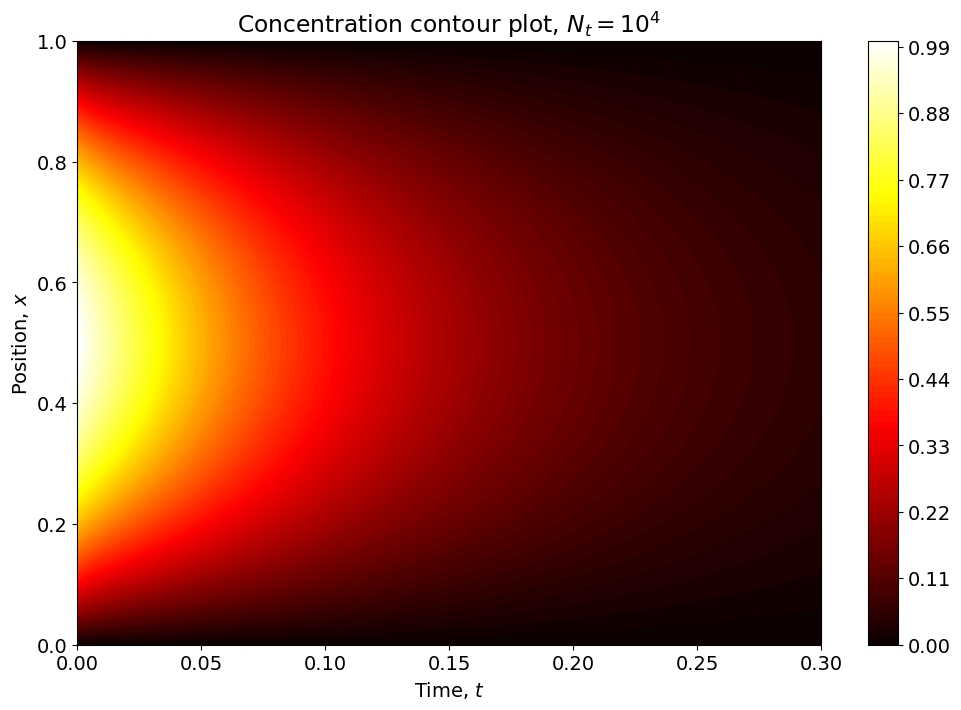

In [3]:
# Define the initial condition function
def ic(x):
    return 4*x*(1-x)

# Create an empty class to contain our parameters
class params:
    pass

par = params()
par.xmin = 0
par.xmax = 1
par.T = 0.3
par.D = 1
par.ul = 0
par.ur = 0
par.Nx = 101
par.Nt = 10000
par.f = ic

# Solve the problem with finite differences 
xs,ts,us=diffusion_btcs_dirichlet(par)

# Plot the solution
fig, ax = plt.subplots()
T, X = np.meshgrid(ts, xs)
c = plt.contourf(T, X, us, 100, cmap ="hot",vmin=0, vmax=1)
  
cbar = plt.colorbar(c)

ax.set_title('Concentration contour plot, $N_t = 10^4$')
ax.set_ylabel(r'Position, $x$')
ax.set_xlabel(r'Time, $t$')

plt.show()

As expected, we have obtained the same result as when using the FTCS scheme. Now let's try to increase the size of our timestep outside the range of stability for the FTCS scheme. 

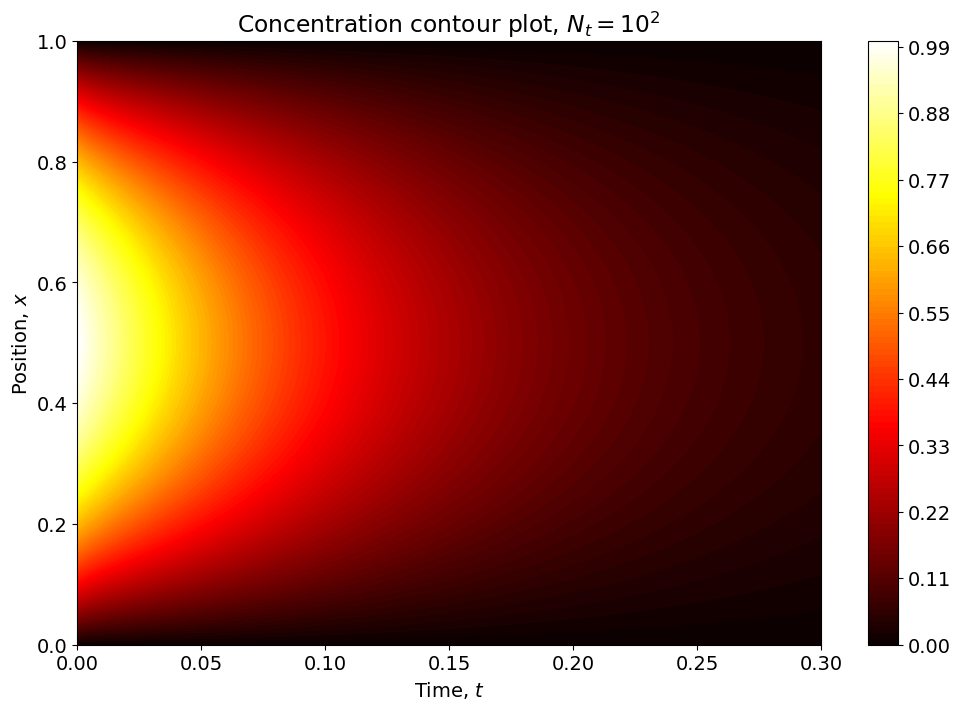

In [4]:
# Define the initial condition function
def ic(x):
    return 4*x*(1-x)

# Create an empty class to contain our parameters
class params:
    pass

par = params()
par.xmin = 0
par.xmax = 1
par.T = 0.3
par.D = 1
par.ul = 0
par.ur = 0
par.Nx = 101
par.Nt = 100
par.f = ic

# Solve the problem with finite differences 
xs,ts,us=diffusion_btcs_dirichlet(par)

# Plot the solution
fig, ax = plt.subplots()
T, X = np.meshgrid(ts, xs)
c = plt.contourf(T, X, us, 100, cmap ="hot",vmin=0, vmax=1)
  
cbar = plt.colorbar(c)

ax.set_title('Concentration contour plot, $N_t = 10^2$')
ax.set_ylabel(r'Position, $x$')
ax.set_xlabel(r'Time, $t$')

plt.show()

Here, we have increased the size of the timestep by a factor of 100! The FTCS scheme would be completely unstable in this range of timesteps, but our BTCS scheme behaves very well. However, as the scheme is only first-order accurate in time, our solution accuracy will be strongly impacted by our increase in timestep size.

## BTCS method with Neumann boundary conditions
---
Let us now try to adapt our BTCS scheme in the case where we are given Neumann boundary conditions. The problem we will try to solve is given by 
$$
\begin{aligned}
&\frac{\partial u}{\partial t} = \frac{\partial^2 u}{\partial x^2}, \quad -L<x<L, t>0 \\
&\frac{\partial u}{\partial x}(-L,t) = \frac{\partial u}{\partial x}(L,t) = 0 \\
&u(x,t) = \exp(-x^2)
\end{aligned}
$$

As we saw in the lecture, one then needs to be careful about the application of the BTCS scheme on the grid points at the boundary of the domain

Following on what we did in the lectures notes, we define $x_{-1}$ and $x_{N+1}$ as being exterior to the domain on which we are trying to solve this problem. To parallel what we have done in lectures, we will assume that our domain is defined by the interval $[0,L]$. This is just for ease of notation, what we are writing here is independent of the actual values of the boundaries of our interval. 

Now, at $x_0=0$, we want to impose the Neumann boundary condition 
$$
\frac{\partial u}{\partial x}(0,t) = v_L(t) \approx \frac{u_{1,n}-u_{-1,n}}{2\Delta x}
$$
where we approximated the derivative of $u$ using a central difference formula. This allows us to write an expression for $u_{-1,n}$ which only involves either known quantities or values of the solutions at grid points actually inside the domain
$$
u_{-1,n} = u_{1,n} - 2 \Delta x v_L(t_n)
$$
Similarly, at $x_N = L$, we impose the Neumann boundary condition and write
$$
\frac{\partial u}{\partial x}(L,t) = v_R(t) \approx \frac{u_{N+1,n} - u_{N-1,n}}{2 \Delta x}
$$
which after rearranging terms allows us to write 
$$
u_{N+1,n} = u_{N-1,n} + 2 \Delta x v_R(t_n)
$$

Now that we have a way to express the value of the solution at these exterior grid points as a function of values on the interior of the domain (and the boundary conditions), we can write the BTCS scheme first on the interior points as 
$$
u_{i,n+1} = u_{i,n} + \alpha ( u_{i+1,n+1} - 2 u_{i,n+1} + u_{i-1,n+1}), \quad i \in [1,N-1]
$$

and secondly, on the boundaries of the domain as
$$
\begin{aligned}
u_{0,n+1} &= u_{0,n} + \alpha \left[  u_{-1,n+1} - 2  u_{0,n+1} +  u_{1,n+1}  \right] \\
		&= u_{0,n} + \alpha \left[  2 u_{1,n+1} - 2  u_{0,n+1}\right] -2\alpha\Delta x v_L(t_{n+1}) \\
u_{N,n+1} &= u_{N,n} + \alpha \left[ u_{N-1,n+1} - 2  u_{N,n+1} + u_{N+1,n+1}\right] \\
		&= u_{N,n} + \alpha \left[ 2u_{N-1,n+1} - 2  u_{N,n+1} \right] + 2 \alpha \Delta x v_R(t_{n+1})
\end{aligned}
$$

Finally, we can conclude that the BTCS scheme with Neumann boundary conditions can be written in matrix form as
$$
A\mathbf{u}_{n+1} = \mathbf{u}_n + \mathbf{b}_{n+1}
$$
with $A$ the following tridiagonal matrix
$$
A = \begin{pmatrix}
1+2\alpha & -2\alpha & 0  & 0  & 0 \\
-\alpha & 1+2\alpha & -\alpha & 0  & 0 \\
0 & -\alpha & 1+2\alpha  & -\alpha  & 0 \\
0 & 0 &  -\alpha & 1+2\alpha  & -\alpha \\
0 & 0 &  0 & -2\alpha  & 1+2\alpha
\end{pmatrix}
$$
and $\mathbf{b}_{n+1}$ the following $(N+1)$ dimensional vector
$$
\mathbf{b}_n = \begin{pmatrix}
-2\alpha \Delta x~v_L(t_{n+1})\\
0\\
0\\
0\\
2\alpha \Delta x~v_R(t_{n+1})\\
\end{pmatrix}
$$
(where we have used here without loss of generality $N+1=5$). 


Now that we understand how to take into account these boundary conditions, let us implement this numerical scheme!

In [5]:
def diffusion_btcs_neumann(par):
    # BTCS scheme with neumann boundary conditons for the diffusion equation in 1D
    # This function takes as input: 
    # - par: a class containing the parameters of the simulation
    # It returns
    # - us: 2D array containing the solution surface
    # - xs: 1D array containing the location of the grid points
    # - ts: 1D array containing the value of the times at which the solution is available
    
    # Domain definition
    xmin = par.xmin
    xmax = par.xmax 
    T = par.T
    D = par.D

    # Boundary conditions (assume to be constant over time)
    vl = par.vl
    vr = par.vr 

    # Number of discretization points in space and time
    Nx = par.Nx
    Nt = par.Nt

    # Spatial and temporal step size
    dx = (xmax-xmin)/(par.Nx-1) 
    dt = T/(par.Nt-1) 

    # Prepare the data structure
    ts = np.linspace(0,T,Nt)
    xs = np.linspace(xmin,xmax,Nx)
    us = np.zeros((len(xs),len(ts)))

    # Initialize the system with initial conditions
    us[:,0] = par.f(xs)
    up = us[:,0] # we are solving for interior points

    # Define the matrices
    a = D*dt/dx**2

    d1 = np.diag(     -a*np.ones(Nx-1),-1)
    d2 = np.diag((1+2*a)*np.ones(Nx  ), 0)    
    d3 = np.diag(     -a*np.ones(Nx-1),+1)
    A = d1 + d2 + d3
    A[0,1] = -2*a
    A[-1,-2] = -2*a
    Ainv = inv(A)
    
    b = np.zeros(Nx)
    b[0] = -2*a*dx*vl
    b[-1] = 2*a*dx*vr
    
    # For loop over time to advance the solution 
    for iT in range(1,Nt):
        un = np.matmul(Ainv,up+b)
        us[:,iT] = un
        up = un
        
    return xs,ts,us

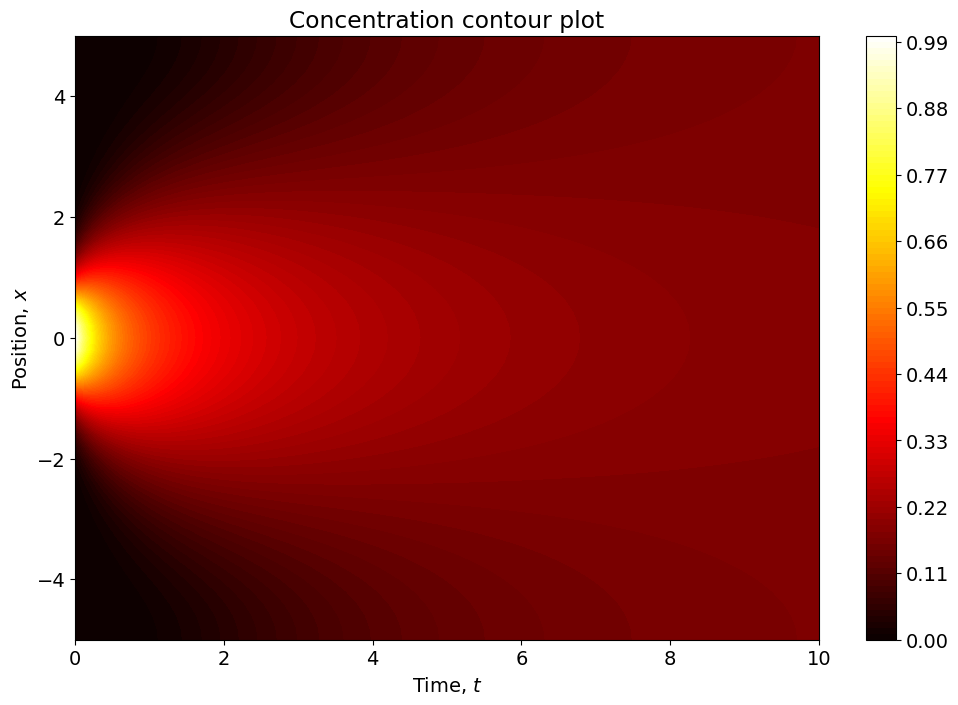

In [6]:
# Define the initial condition function
def ic(x):
    return np.exp(-x**2)

# Create an empty class to contain our parameters
class params:
    pass

par = params()
par.xmin = -5
par.xmax =  5
par.T = 10
par.D = 1
par.vl = 0
par.vr = 0
par.Nx = 51
par.Nt = 200
par.f = ic

# Solve the problem with finite differences 
xs,ts,us=diffusion_btcs_neumann(par)

# Plot the solution
fig, ax = plt.subplots()
T, X = np.meshgrid(ts, xs)
c = plt.contourf(T, X, us, 100, cmap ="hot",vmin=0, vmax=1)
  
cbar = plt.colorbar(c)

ax.set_title('Concentration contour plot')
ax.set_ylabel(r'Position, $x$')
ax.set_xlabel(r'Time, $t$')

plt.show()